# Beiwe-visualizer

In [1]:
import os, sys
# Please specify data file path here:
# folder hierarchy: main-path/study-name/user-name/feature-name/[timestamp-sortable].csv or main-path/study-name/user-name/feature-name.csv.gz
# os.main_path = os.getenv('HOME')+''
os.main_path = os.getenv('HOME')+'/projects/beiwe-gitlab/beiwe-backend/3.decrypted/'

# disable autosave so that multiple user browser can attach the same notebook
%autosave 0

# enable notebook mode so that we can drag, resize and save plots
%matplotlib notebook

from core import *

Autosave disabled


<IPython.core.display.Javascript object>

In [2]:
HBox([dropdown_studies, fileupload])

# Master Configuration Dashboard

In [3]:
VBox([HBox(W.children[0:5]), HBox(W.children[5:10]), HBox(W.children[10:15]), HBox(W.children[15:-1]), W.children[-1]])

# Monitoring Dashboard

In [4]:
def merge_stat(dfs, max_datetime):
    s = pd.DataFrame([df['timestamp'].groupby(pd.Grouper(freq='D')).count() for df in dfs if len(df.index)]).transpose().sum(axis=1)
    return pd.DataFrame({'timestamp':s}) if s.size else pd.DataFrame({'timestamp':[0]}, index=[max_datetime])

def monitor(lastN, x):
    if not x:
        return clear_output()
    df = pd.DataFrame()
    for username in dropdown_userlist.options:
        if not os.path.isfile(os.data_path+'/'+username+'/ambientLight.csv.gz'):
            print('Skipping User %s'%username)
            continue
            
        print('Loading data from %s '%username, end='')
        os.dfs = dfs = [(load_df(username, fn, -1),print('.', end='', flush=True))[0] for fn in ['ambientLight.csv.gz', 'accessibilityLog.csv.gz', 'tapsLog.csv.gz',
                'callLog.csv.gz', 'smsLog.csv.gz', 'sociabilityMsgLog.csv.gz', 'sociabilityCallLog.csv.gz', 'heart.csv.gz', 'sleep.csv.gz', 'steps.csv.gz']]
        max_datetime = max([df.index.max() for df in dfs if len(df.index)])
        os.all5 = phone1, phone2, phone3, fitbit1, fitbit2 = [merge_stat([dfs[i] for i in s], max_datetime) for s in [[0], [1,2], [3,4,5,6], [7], [8]]]
        
        # Fitbit steps need to sum over every day group
        os.fitbit0 = fitbit0 = (dfs[9] if len(dfs[9].index) else pd.DataFrame({'StepsCount':[0]},
                    index=[max_datetime]))[['StepsCount']].groupby(pd.Grouper(freq='D')).sum()
        
        # Build phone colors
        os.phoneC = df[username+' phone'] = pd.concat([phone1, phone2, phone3], axis=1).fillna(0).sort_index()\
                .apply(lambda x: 3 if x[2] else (2 if x[1] else (1 if x[0] else 0)), axis=1)

        # Build Fitbit colors
        os.fitbitC = df[username+' fitbit'] = pd.concat([fitbit0, fitbit1, fitbit2], axis=1).fillna(0).sort_index()\
                .apply(lambda x: 3 if x[2] else (2 if x[1] else (1 if x[0] else 0)), axis=1)
        
        print('Done')
        
    print('Plotting dashboard ...')
    plt.switch_backend('module://ipykernel.pylab.backend_inline')
    os.df = df = df.fillna(0).astype(int)
    os.data = data = df.iloc[-lastN:, :].transpose()
    
    # draw 2D grid
    Nx, Ny = len(data.columns), len(data.index)
    fig, ax = plt.subplots(figsize=(Nx/4,Ny))
    ax.title.set_size(30)
    ax.title.set_text('Participant Data Completion Dashboard')
    cmap = colors.ListedColormap(['black', 'red', 'orange', 'green'])
    norm = colors.BoundaryNorm([-1,0.5,1.5,2.5,3.5], cmap.N)
    ax.grid(False)
    ax.imshow(data, cmap=cmap, norm=norm)

    # x-axis is the date
    ax.set_xticklabels('')
    ax.set_xticks(np.arange(0.5, Nx+0.5, 1), minor=True)
    ax.set_xticklabels(data.columns, minor=True, rotation=45, ha='right')
    ax.xaxis.grid(True, which='minor', linewidth=0.5)
    
    # y-axis is the Patient ID
    ax.set_yticks(np.arange(-0.5, Ny+0.5, 2))
    ax.set_yticklabels(['']+[re.sub('@[^ ]* ',' ',s) for s in data.index[1::2]], fontdict={'family':'monospace'}, va='bottom')
    ax.yaxis.grid(True, which='major', linewidth=2)
    
    ax.set_yticks(np.arange(0.5, Ny+0.5, 2), minor=True)
    ax.set_yticklabels([re.sub('@[^ ]* ',' ',s) for s in data.index[0::2]], fontdict={'family':'monospace'}, minor=True, va='bottom')
    ax.yaxis.grid(True, which='minor', linewidth=0.5)
    
    # legend
    ax.add_artist(plt.legend(handles=[Patch(color='green', label='sensor+taps+social'), Patch(color='orange', label='sensor+taps'),
                        Patch(color='red', label='sensor only'), Patch(color='black', label='no data')], title='Phone',
                        loc='lower center', bbox_to_anchor=(0.1, 1)))
    ax.add_artist(plt.legend(handles=[Patch(color='green', label='steps+heart+sleep'), Patch(color='orange', label='steps+heart'),
                        Patch(color='red', label='steps only'), Patch(color='black', label='no data')], title='Fitbit',
                        loc='lower center', bbox_to_anchor=(0.9, 1)))

    plt.show()
    
W = interactive(monitor, lastN=widgets.IntText(value=90, description='Last N days:'),
          x=ToggleButton(value=False, description='Show Monitor Dashboard', layout=Layout(width='200pt')))
VBox([HBox(W.children[0:-1]), W.children[-1]])

# Overview Dashboard

In [5]:
def group_dates(data, labels, figsize):
    periods = [(s+'D' if s.isdigit() else s) for s in re.split('[ ,;]+', os.DateGroup)]
    index = data.index if type(data.index) == pd.DatetimeIndex else data.datetime
    max_date = index.max().floor('D')
    cut_points = [max_date]
    for period in periods[::-1]:
        max_date -= pd.to_timedelta(period)
        cut_points = [max_date] + cut_points
    dfg = data.groupby(pd.cut(index, cut_points, right=False))
    figsize[0] = len(periods)*0.4
    if index.nunique()==len(data):
        ret = dfg.mean()
        ret_index = ret.index
    else:
        ret = pd.concat([set_index_to_value(v.reset_index(drop=True), k, 'datetime') for k,v in dfg], ignore_index=True)
        ret_index = [k for k,v in dfg]
    return ret, ret_index, figsize

def drawAll(Username, StartDate, LastDate, DateGroup, DoPlot):
    if not DoPlot:
        clear_output()
        return
    
    PP = None
    if DateGroup:
        os.DateGroup = DateGroup
        PP = group_dates
    
    # init parameters
    file_suffix = '.csv.gz'
    plt.switch_backend('module://ipykernel.pylab.backend_inline')
    
    # arrange into horizontal grid
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=[16,4])
    
    # sociability messages
    df = load_df(Username, 'sociabilityMsgLog'+file_suffix).copy()
    df.orientation = df.orientation.apply(lambda t: ('outgoing' if t==0 else 'incoming'))
    plot1a = draw(df, StartDate, LastDate, 0.0, False, 'sociabilityMsgLog'+file_suffix, 'grouped values by each interval', '1D', 0.0, 0, 'time chart stacked bar', 'orientation', 10,
                  '<entry-count>', True, 'no sort', True, False, False, False, None, post_processor=PP, ax=axs[0], set_title='WhatsApp Messages', set_ylabel='log(total#)')
    
    plot1b = draw(Username, StartDate, LastDate, 0.0, False, 'textsLog'+file_suffix, 'grouped values by each interval', '1D', 0.0, 0, 'time chart stacked bar', 'sent vs received', 10,
                  '<entry-count>', True, 'no sort', True, False, False, False, None, post_processor=PP, ax=axs[1], set_title='SMS Messages', set_ylabel='log(total#)')
    
    # sociability calls
    df = load_df(Username, 'sociabilityCallLog'+file_suffix)[['recordedDuration']]
    df = df.append(load_df(Username, 'callLog'+file_suffix)[['duration in seconds']].rename(columns={'duration in seconds':'recordedDuration'}))
    plot2 = draw(df.sort_index()/60, StartDate, LastDate, 0.0, False, 'sociabilityCallLog'+file_suffix, 'sum in each interval', '1D', 0.0, 0, 'time chart (bar)', 'recordedDuration', 10,
                 '<entry-count>', False, 'no sort', False, False, False, False, None, post_processor=PP, ax=axs[2], set_title='WhatsApp/Phone Call Duration', set_ylabel='minutes')
    
    # sleep stage
    df = load_df(Username, 'sleep'+file_suffix).copy()
    df = df[df.Level!='main']
    df.loc[:,'Seconds'] = df.Seconds/3600
    plot3 = draw(df, StartDate, LastDate, 0.0, False, 'sleep'+file_suffix, 'grouped values by each interval', '1D', 0.5, 0, 'time chart stacked bar', 'Level', 10,
                 'Seconds', True, 'no sort', False, False, False, False, None, post_processor=PP, ax=axs[3], set_title='Sleep Stage', set_ylabel='hours')
    
    # sleep efficiency
    plot4 = draw(Username, StartDate, LastDate, 0.0, False, 'sleep'+file_suffix, 'mean value in each interval', '1D', 0.5, 0, 'time chart (bar)', 'Efficiency', 10,
                 '<entry-count>', True, 'no sort', False, False, False, False, None, post_processor=PP, ax=axs[4], set_title='Sleep Efficiency', set_ylabel='%')
    
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=[16,4])
    
    # mobility: Radius of Gyration
    plot5 = draw(Username, StartDate, LastDate, 0.0, False, 'gps-mobility'+file_suffix, 'mean value in each interval', '1D', 0.0, 0, 'time chart (bar)', 'RoG', 'mean',
                 '<entry-count>', True, 'no sort', False, False, False, False, None, post_processor=PP, ax=axs[0], set_title='Mobility: Radius of Gyration', set_yscale='log', set_ylabel='m')
    
    # mobility: home time
    plot6 = draw(Username, StartDate, LastDate, 0.0, False, 'gps-mobility'+file_suffix, 'mean value in each interval', '1D', 0.0, 0, 'time chart (bar)', 'Hometime', 'mean',
                 '<entry-count>', True, 'no sort', False, False, False, False, None, post_processor=PP, ax=axs[1], set_title='Mobility: Home Time', set_ylabel='minutes')
    
    # mobility: steps
    plot7 = draw(Username, StartDate, LastDate, 0.0, False, 'steps'+file_suffix, 'sum in each interval', '1D', 0.0, 0, 'time chart (bar)', 'StepsCount', 'mean',
                 '<entry-count>', True, 'no sort', False, False, False, False, None, post_processor=PP, ax=axs[2], set_title='Mobility: Steps')
    
    # taps in Apps
    plot8 = draw(Username, StartDate, LastDate, 0.0, False, 'tapsLog'+file_suffix, 'grouped values by each interval', '1D', 0.0, 0, 'time chart stacked bar', 'in_app_class', 10,
                 '<entry-count>', True, 'no sort', True, False, False, False, None, post_processor=PP, ax=axs[3], set_title='Taps in Apps', set_ylabel='log(total#)')

    # heart rate
    plot9 = draw(Username, StartDate, LastDate, 0.0, False, 'heart'+file_suffix, 'grouped values by each interval', '1D', 0.0, 0, 'time chart grouped box plot', 'HR', 'mean',
                 '<entry-count>', False, 'no sort', False, False, False, False, None, post_processor=PP, ax=axs[4], set_title='Heart Rate', set_ylabel='BPM')
    
#     # ambient light heatmap
#     plot10 = draw(Username, StartDate, LastDate, 0.0, False, 'light'+file_suffix, 'pass through all', '1D', 0.0, 0, 'value heatmap', 'value', 'mean',
#                  '<entry-count>', True, 'no sort', True, False, False, False, None, set_title='Ambient Light Heatmap')
    
date_group0 = Text(value='30 30 7 7', placeholder='Input date group such as "30 7 7"', disabled=False)
W = interactive(drawAll, Username = dropdown_userlist, StartDate = DatePicker(value=None), LastDate = DatePicker(value=None), DateGroup = date_group0, DoPlot = ToggleButton(value=False, description='Update Plot'))
VBox([HBox(W.children[0:-1]), W.children[-1]])

# Detailed Dashboard

In [6]:
def drawAll1(Username, StartDate, LastDate, CyclePeriod, DoPlot):
    if not DoPlot:
        clear_output()
        return
    
    # init parameters
    file_suffix = '.csv.gz'
    
    # sociability messages
    df = load_df(Username, 'sociabilityMsgLog'+file_suffix).copy()
    df.orientation = df.orientation.apply(lambda t: ('outgoing' if t==0 else 'incoming'))
    plot1a = draw(df, StartDate, LastDate, 0.0, False, 'sociabilityMsgLog'+file_suffix, 'grouped values by each interval', '1D', 0.0, CyclePeriod, 'time chart stacked bar', 'orientation', 10,
                  '<entry-count>', True, 'no sort', True, False, False, False, None, set_title='WhatsApp Messages', set_ylabel='log(total#)')
    
    plot1b = draw(Username, StartDate, LastDate, 0.0, False, 'textsLog'+file_suffix, 'grouped values by each interval', '1D', 0.0, CyclePeriod, 'time chart stacked bar', 'sent vs received', 10,
                  '<entry-count>', True, 'no sort', True, False, False, False, None, set_title='SMS Messages', set_ylabel='log(total#)')
    
    # sociability calls
    df = load_df(Username, 'sociabilityCallLog'+file_suffix)[['recordedDuration']]
    df = df.append(load_df(Username, 'callLog'+file_suffix)[['duration in seconds']].rename(columns={'duration in seconds':'recordedDuration'}))
    plot2 = draw(df.sort_index()/60, StartDate, LastDate, 0.0, False, 'sociabilityCallLog'+file_suffix, 'sum in each interval', '1D', 0.0, CyclePeriod, 'time chart (bar)', 'recordedDuration', 10,
                 '<entry-count>', False, 'no sort', False, False, False, False, None, set_title='WhatsApp/Phone Call Duration', set_ylabel='minutes')
    
    # sleep stage
    df = load_df(Username, 'sleep'+file_suffix).copy()
    df = df[df.Level!='main']
    df.Seconds /= 3600
    plot3 = draw(df, StartDate, LastDate, 0.0, False, 'sleep'+file_suffix, 'grouped values by each interval', '1D', 0.5, CyclePeriod, 'time chart stacked bar', 'Level', 10,
                 'Seconds', True, 'no sort', False, False, False, False, None, set_title='Sleep Stage', set_ylabel='hours')
    
    # sleep efficiency
    plot4 = draw(Username, StartDate, LastDate, 0.0, False, 'sleep'+file_suffix, 'mean value in each interval', '1D', 0.5, CyclePeriod, 'time chart (bar)', 'Efficiency', 10,
                 '<entry-count>', True, 'no sort', False, False, False, False, None, set_title='Sleep Efficiency', set_ylabel='%')
    
    # mobility: Radius of Gyration
    plot5 = draw(Username, StartDate, LastDate, 0.0, False, 'gps-mobility'+file_suffix, 'mean value in each interval', '1D', 0.0, CyclePeriod, 'time chart (bar)', 'RoG', 'mean',
                 '<entry-count>', True, 'no sort', False, False, False, False, None, set_title='Mobility: Radius of Gyration', set_yscale='log', set_ylabel='m')
    
    # mobility: home time
    plot6 = draw(Username, StartDate, LastDate, 0.0, False, 'gps-mobility'+file_suffix, 'mean value in each interval', '1D', 0.0, CyclePeriod, 'time chart (bar)', 'Hometime', 'mean',
                 '<entry-count>', True, 'no sort', False, False, False, False, None, set_title='Mobility: Home Time', set_ylabel='minutes')
    
    # mobility: steps
    plot7 = draw(Username, StartDate, LastDate, 0.0, False, 'steps'+file_suffix, 'sum in each interval', '1D', 0.0, CyclePeriod, 'time chart (bar)', 'StepsCount', 'mean',
                 '<entry-count>', True, 'no sort', False, False, False, False, None, set_title='Mobility: Steps')
    
    # taps in Apps
    plot8 = draw(Username, StartDate, LastDate, 0.0, False, 'tapsLog'+file_suffix, 'grouped values by each interval', '1D', 0.0, CyclePeriod, 'time chart stacked bar', 'in_app_class', 10,
                 '<entry-count>', True, 'no sort', True, False, False, False, None, set_title='Taps in Apps', set_ylabel='log(total#)')

    # heart rate
    plot9 = draw(Username, StartDate, LastDate, 0.0, False, 'heart'+file_suffix, 'grouped values by each interval', '1D', 0.0, CyclePeriod, 'time chart grouped box plot', 'HR', 'mean',
                 '<entry-count>', False, 'no sort', False, False, False, False, None, set_title='Heart Rate', set_ylabel='BPM')
    
    # ambient light heatmap
    plot10 = draw(Username, StartDate, LastDate, 0.0, False, 'ambientLight'+file_suffix, 'pass through all', '1D', 0.0, CyclePeriod, 'value heatmap', 'value', 'mean',
                 '<entry-count>', True, 'no sort', True, False, False, False, None, set_title='Ambient Light Heatmap')
    
cycle_period1 = IntSlider(min=0, max=100, step=1, value=0, continuous_update=False, description='Cycle (days)')
W = interactive(drawAll1, Username = dropdown_userlist, StartDate = DatePicker(value=None), LastDate = DatePicker(value=None), CyclePeriod = cycle_period1, DoPlot = ToggleButton(value=False, description='Update Plot'))
VBox([HBox(W.children[0:-1]), W.children[-1]])

## Padding (Jupyter notebook UI has a bug that if the following is removed, the UI will scroll upon every interactive click)

<IPython.core.display.Javascript object>


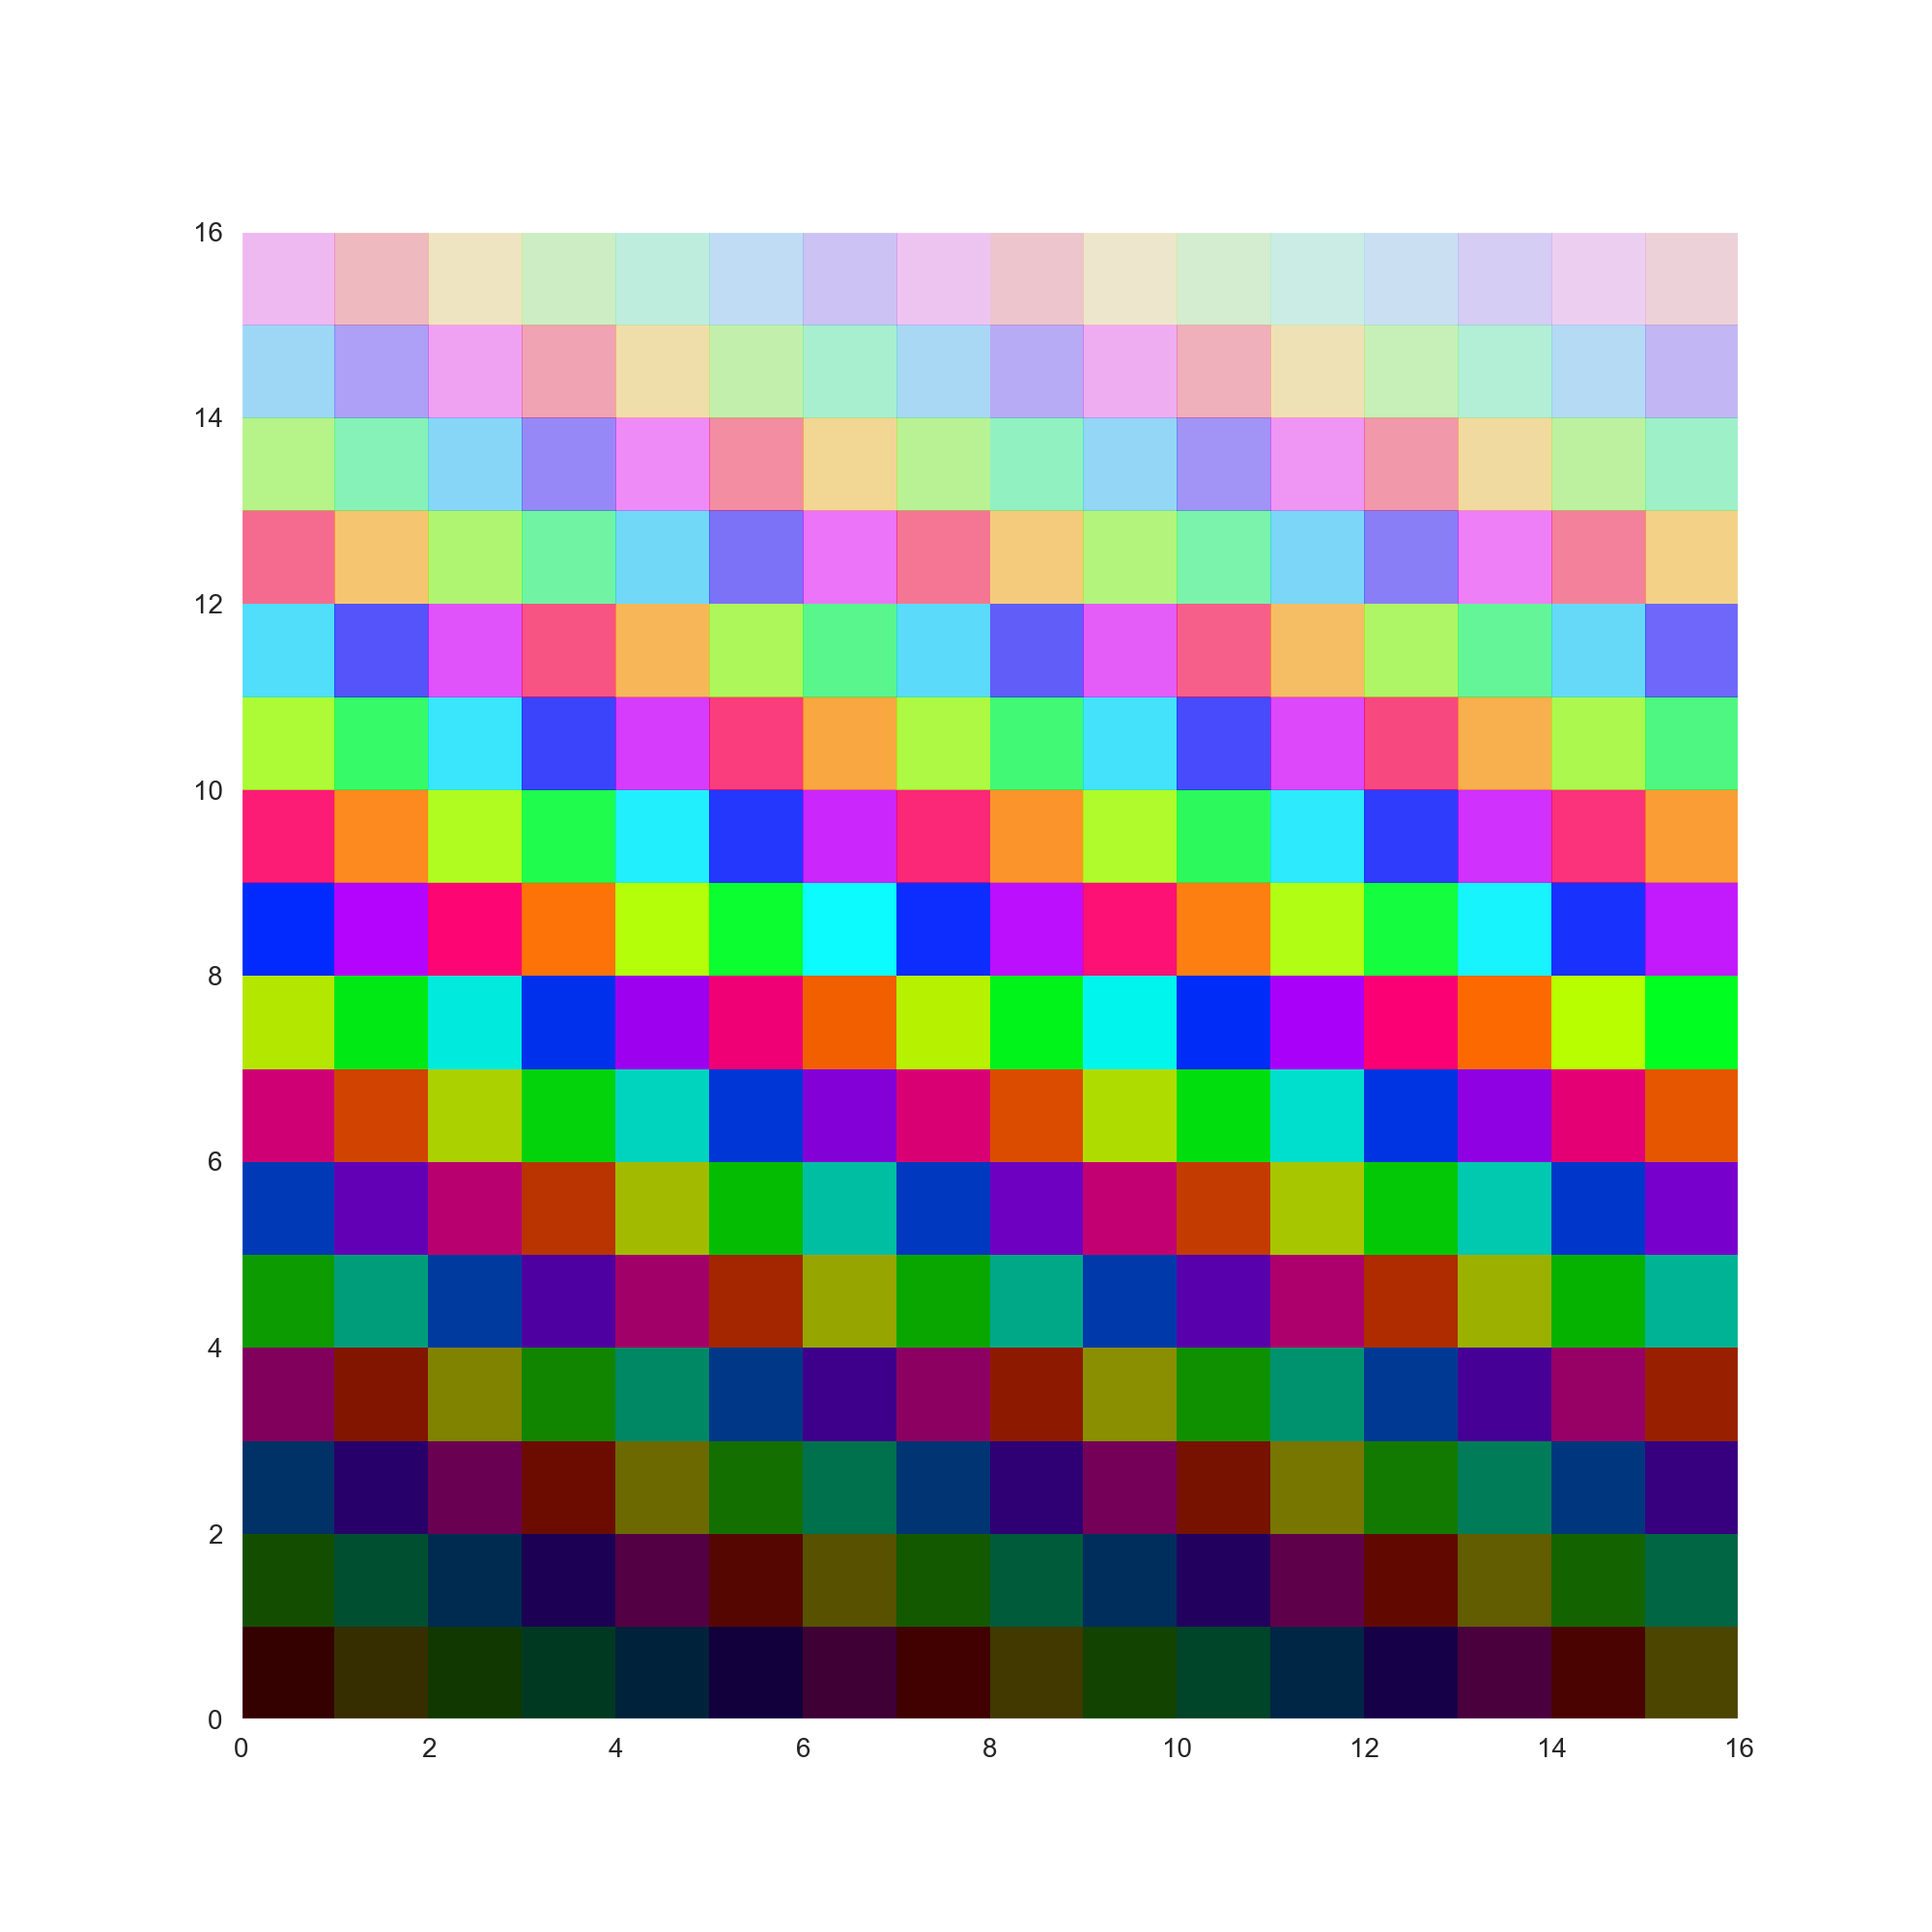

In [7]:
from matplotlib.colors import ListedColormap

plt.switch_backend('nbAgg')

N = 16
H = np.arange(N*N).reshape([N,N])
fig = plt.figure(figsize=(10, 10))
ax = plt.pcolor(H, cmap=ListedColormap(generate_colormap(N*N)))